In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

import astropy.units as u
from astropy.cosmology import Planck18, z_at_value

In [8]:
import matplotlib


font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)


In [13]:
DLs = [400, 600, 800, 1000]
# DLs = [1000]

files = []
for DL in DLs:
    files.append('m1_q_grid_DL_'+str(DL)+'_Mc.csv')
print(files)

['m1_q_grid_DL_400_Mc.csv', 'm1_q_grid_DL_600_Mc.csv', 'm1_q_grid_DL_800_Mc.csv', 'm1_q_grid_DL_1000_Mc.csv']


In [44]:
df = pd.DataFrame()
for fi in files:
    df2 = pd.read_csv(fi)
    df = df.append(df2)

# drop the zero rows that resulted from NoneType Networks
df = df.loc[~(df==0).all(axis=1)]

df = df[df["eta"]>0.08]

# Compute redshifts based on Planck18 cosmology
zs = np.zeros(len(df["DL"]))
for i, dl in enumerate(df["DL"]):
    zs[i] = z_at_value(Planck18.luminosity_distance, dl * u.Mpc)

# Compute m1, m2 for plots
mass1 = (df["q"]**(2./5.))*((1.0 + df["q"])**(1./5.))*df["Mc"]
mass2 = (df["q"]**(-3./5.))*((1.0 + df["q"])**(1./5.))*df["Mc"]

# Separate data into unbiased and unfaithful
unbiased_mask = np.abs(df["full_bias"])/df["Mc_stat_err"] < 1.0
faith_mask = np.abs(df["full_faith"]) > (df["Mc_min_faith"])

print("Total number of events:",len(df))
print("Total number of events with unbiased Mc:", np.sum(unbiased_mask))
print("Total number of events with faithfulness above calculated threshold:", np.sum(faith_mask))
print("Overlap between bias and faithfulness criteria:", len(df[unbiased_mask*faith_mask]))

df.head()

Total number of events: 883
Total number of events with unbiased Mc: 0
Total number of events with faithfulness above calculated threshold: 83
Overlap between bias and faithfulness criteria: 0


,Mc,eta,DL,M_tot,q,full_bias,full_faith,snr,Mc_stat_err,Mc_max_lam,Mc_min_faith
0,56.308974,0.249586,400.0,129.492883,1.084883,1.090780,0.991897,2801.598025,0.001704,0.018307,0.999612
1,15.466218,0.096725,400.0,62.814484,8.216844,0.010295,0.998764,924.178593,0.000099,0.151991,0.995607
2,29.966005,0.249617,400.0,68.907241,1.081525,0.128848,0.992659,1749.074688,0.000349,0.041320,0.998809
3,70.768601,0.249073,400.0,162.946201,1.129657,2.229878,0.993766,3307.988960,0.003176,0.013219,0.999777
4,46.806718,0.235555,400.0,111.442983,1.632875,0.596591,0.993665,2404.554870,0.001068,0.018307,0.999671


Why am I seeing so many events where the minimum required faithfulness is lower than IMRPhenomD, but still the bias is larger than statistical error?


One possible reason is that my computed faithfulness is using the entire frequency range, whereas the chirp mass estimation relies mostly on early inspiral.

In [45]:
def plot_bias_features(x, y, feature, show_unbiased=False, DL=None, colormap='RdBu_r',\
        xlabel="Mc ($M_\odot$)", ylabel="$\eta", cbar_label="Faithfulness",\
        title="Minimum Faithfulness required \nfor unbiased Mc", xlim=None, ylim=None, plt_show=True, **kwargs):

    if DL is not None:
        x = x[df["DL"]==DL]
        y = y[df["DL"]==DL]
        feature = feature[df["DL"]==DL]
        title = title + " (DL=" + str(DL) + " Mpc)"

    fig, ax = plt.subplots(figsize=(8, 6))
    cm = plt.cm.get_cmap(colormap)

    sc = plt.scatter(x, y, c=feature, cmap=cm, **kwargs)
    cbar = plt.colorbar(sc)
    cbar.set_label(cbar_label)

    if show_unbiased:
        plt.scatter(x[unbiased_mask], y[unbiased_mask], c="white",  s=100, edgecolors='g', lw=3, label='Unbiased')
        plt.legend()

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.tight_layout()

    if plt_show:
        plt.show()


# Overall Population

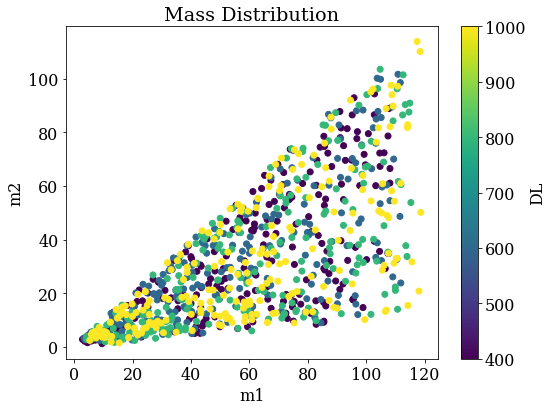

In [46]:
# Mass Distribution
plot_bias_features(mass1, mass2, df["DL"], colormap="viridis",\
    title="Mass Distribution", xlabel="m1", ylabel="m2", cbar_label="DL")

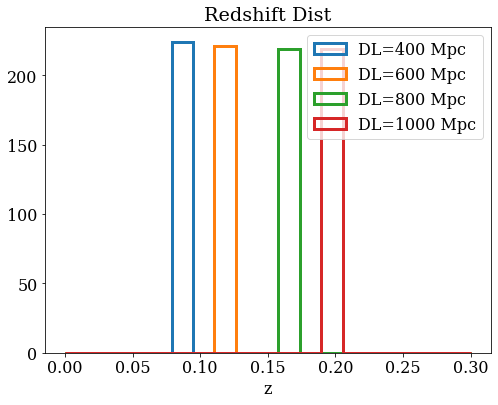

In [47]:
# Redshift Distribution
fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(0, 0.30, 20)
for DL in DLs:
    distance_mask = df["DL"] == DL
    plt.hist(zs[distance_mask], bins, histtype='step', lw=3, label=f"DL={DL} Mpc")

plt.xlabel("z")
plt.ylabel("")
plt.legend()
plt.title("Redshift Dist")
plt.show()

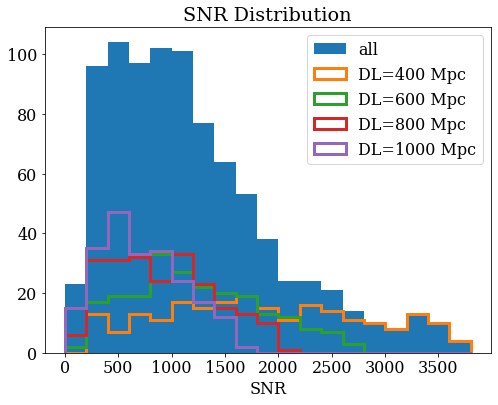

In [48]:
# SNR Distribution
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(0, np.max(df["snr"]), 20)

plt.hist(df["snr"], bins, label="all")

for DL in DLs:
    distance_mask = df["DL"] == DL
    plt.hist(df["snr"][distance_mask], bins, histtype='step', lw=3, label=f"DL={DL} Mpc")

plt.xlabel("SNR")
plt.ylabel("")
plt.legend()
plt.title("SNR Distribution")
plt.show()

# Features

## Overall Faithfulness of IMRPhenomD depends on Mc, eta (or M_tot, q)

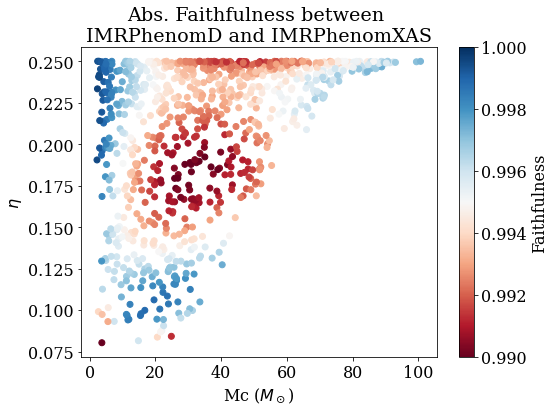

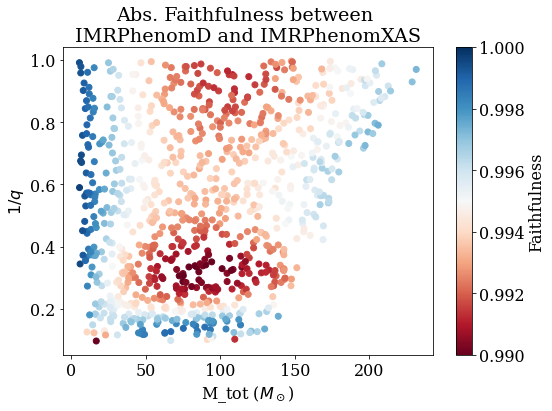

In [49]:
plot_bias_features(df["Mc"], df["eta"], df["full_faith"], show_unbiased=False, colormap="RdBu", 
    title="Abs. Faithfulness between \nIMRPhenomD and IMRPhenomXAS", xlabel="Mc ($M_\odot$)", ylabel="$\eta$", cbar_label="Faithfulness",\
        vmin=0.99, vmax=1.0)

plot_bias_features(df["M_tot"], 1/df["q"], df["full_faith"], show_unbiased=False, colormap="RdBu", 
    title="Abs. Faithfulness between \nIMRPhenomD and IMRPhenomXAS", xlabel="M_tot ($M_\odot$)", ylabel="$1/q$", cbar_label="Faithfulness",\
        vmin=0.99, vmax=1.0)

### On the M_tot vs q plot:

In general, we see that more massive events give lower faithfulness between IMRPhenomXAS and IMRPhenomD. There seem to be some values of q for which the models are in particularly poor agreement.

Bottom red line: The faithfulness is clearly very bad for the most extreme mass ratio events. 

Left vertical blue strip: The agreement is typically better for low total masses (where IMRPhenomD must be better calibrated).

Right-most blue band: IMRPhenomD starts to extrapolate after some M_tot, which makes it behave more like IMRPhenomXAS. We see this also in the bias starting to decrease around M_tot ~ 150 and Mc ~ 80.

Horizontal blue band: Faithfulness appears to be really good for q ~ 6 or 7 (1/q ~ 0.15)

## The Mc bias is more significant for nearby events

For a given event (e.g. for a given chirp mass), the lower the luminosity distance, the more significant the bias between IMRPhenomXAS and IMRPhenomD.

For a given luminosity distance, the bias becomes more significant at higher chirp mass, which agrees with the trend of higher mass giving lower faithfulness above. At the highest chirp mass, the statistical error keeps increasing but the bias goes back down. This is probably because of differences between IMRPhenomD and IMRPhenomXAS at high chirp masses.

See https://arxiv.org/pdf/2001.11412.pdf, right after Eq. 5.2 for the maximum total mass for which IMRPhenomD is calibrated.

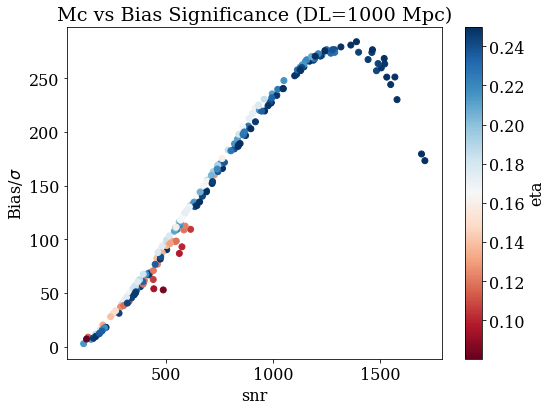

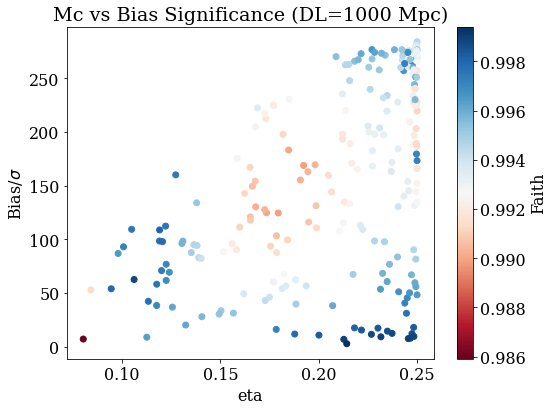

In [68]:
plot_bias_features(df["snr"], (df["full_bias"]/df["Mc_stat_err"]), df["eta"], DL=1000, colormap="RdBu",\
    title="Mc vs Bias Significance", xlabel="snr", ylabel="Bias/$\sigma$", cbar_label="eta")
plot_bias_features(df["eta"], (df["full_bias"]/df["Mc_stat_err"]), df["full_faith"], DL=1000, colormap="RdBu",\
    title="Mc vs Bias Significance", xlabel="eta", ylabel="Bias/$\sigma$", cbar_label="Faith")


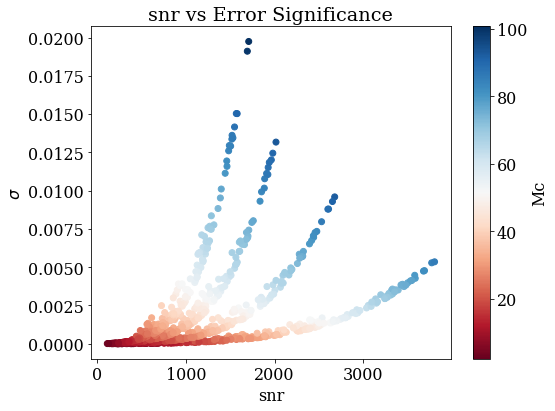

In [73]:
plot_bias_features(df["snr"], (df["Mc_stat_err"]), df["Mc"], DL=None, colormap="RdBu",\
    title="snr vs Error Significance", xlabel="snr", ylabel="$\sigma$", cbar_label="Mc")

## Required Accuracy (faithfulness) is higher for nearby events

The minimum faithfulness is the faithfulness required to keep Cutler-Vallisneri bias to below the 1$\sigma$ statistical error on Mc.

There are more high minFaith events for DL=400 compared to DL=1000 Mpc. This is because nearby events have higher SNRs and lower statistical errors, and so are more easily biased by an unfaithful waveform model. (See Below).

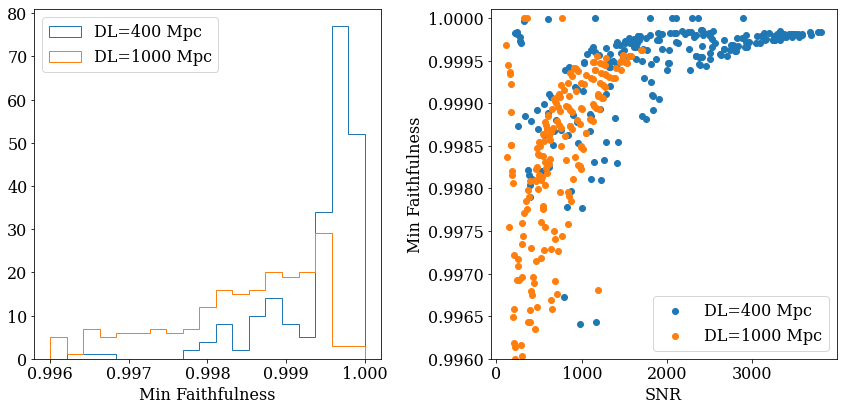

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

x1 = df["snr"][df["DL"]==400]
y1 = df["Mc_min_faith"][df["DL"]==400]

x2 = df["snr"][df["DL"]==1000]
y2 = df["Mc_min_faith"][df["DL"]==1000]


bins = np.linspace(0.996, 1.0, 20)
ax1.hist(y1, bins, histtype='step', label="DL=400 Mpc")
ax1.hist(y2, bins, histtype='step', label="DL=1000 Mpc")
ax1.set_xlabel("Min Faithfulness")
ax1.set_xticks(np.linspace(0.996, 1.0, 5))
ax1.legend(loc="upper left")

ax2.scatter(x1, y1,  label="DL=400 Mpc")
ax2.scatter(x2, y2, label="DL=1000 Mpc")
ax2.set_xlabel("SNR")
ax2.set_ylabel("Min Faithfulness")
ax2.set_ylim(0.996, 1.0001)
ax2.legend()

fig.tight_layout()
plt.show()

Again, note the relative abundance of red (high minFaith) events for DL=400 Mpc compared to DL=1000 Mpc below

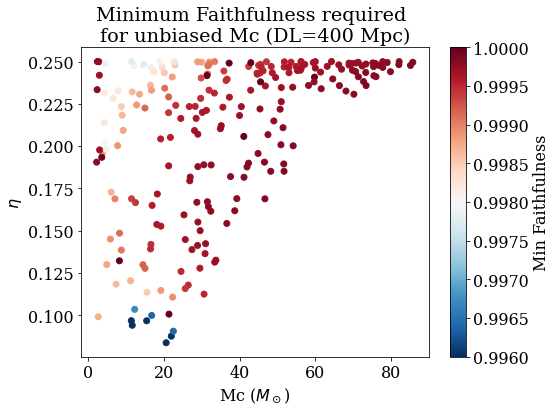

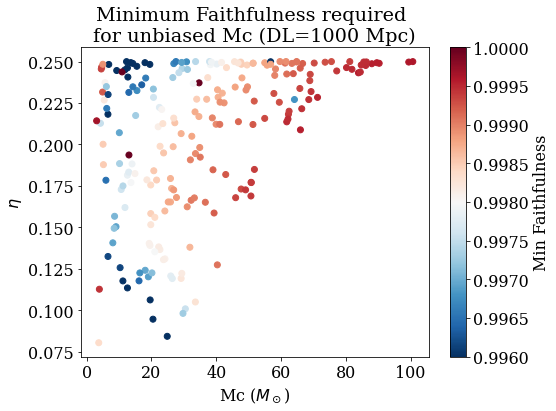

In [52]:
plot_bias_features(df["Mc"], df["eta"], df["Mc_min_faith"], show_unbiased=False,  DL=400,\
    xlabel="Mc ($M_\odot$)", ylabel="$\eta$", cbar_label="Min Faithfulness", vmin=0.996,vmax=1.0)

plot_bias_features(df["Mc"], df["eta"], df["Mc_min_faith"], show_unbiased=False,  DL=1000,\
    xlabel="Mc ($M_\odot$)", ylabel="$\eta$", cbar_label="Min Faithfulness", vmin=0.996,vmax=1.0)


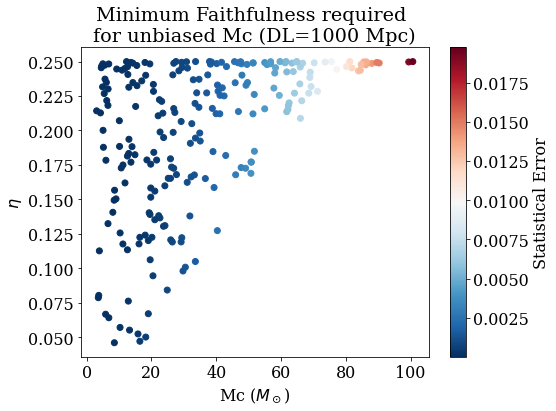

In [19]:
plot_bias_features(df["Mc"], df["eta"], df["Mc_stat_err"], show_unbiased=False,  DL=1000,\
    xlabel="Mc ($M_\odot$)", ylabel="$\eta$", cbar_label="Statistical Error")

## The sign of the bias depends on eta (or q)

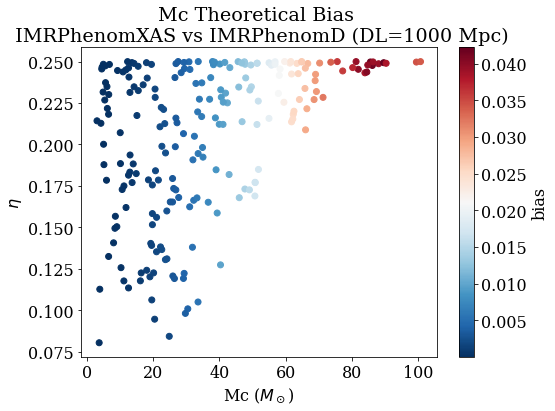

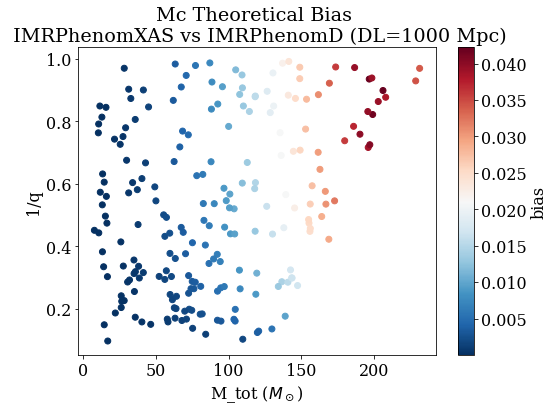

In [53]:
err_ratio = df["full_bias"]/df["Mc"]
err_lim = np.max(np.abs(err_ratio)/5)

plot_bias_features(df["Mc"], df["eta"], err_ratio, show_unbiased=False, DL=1000, xlabel="Mc ($M_\odot$)", ylabel="$\eta$",\
    title="Mc Theoretical Bias \n IMRPhenomXAS vs IMRPhenomD", cbar_label="bias")#, vmin=-err_lim, vmax=err_lim)

plot_bias_features(df["M_tot"], 1/df["q"], err_ratio, show_unbiased=False, DL=1000,xlabel="M_tot ($M_\odot$)", ylabel="1/q",\
    title="Mc Theoretical Bias \n IMRPhenomXAS vs IMRPhenomD", cbar_label="bias")#, vmin=-err_lim, vmax=err_lim)

The lowest Mc binaries have very low SNR. Thus, the biases tend to be lower for these low mass systems.

To see the flipping of the eta sign, we must consider binaries with high enough SNRs (== high enough Mcs).

In [54]:
low_bias_mask = np.abs(df["full_bias"])/df["Mc_stat_err"] < 10.0
significant_snr_mask = df["snr"] > 300

df_eta_flip = df[low_bias_mask * significant_snr_mask]
eta_flip = np.average(df_eta_flip["eta"])

print(f"Eta seems to flip around {eta_flip:.3f}")
print("this corresponds to q=", 1/0.0685)

# Pratten+ 2020 (IMRPhenomX family paper)
# https://arxiv.org/pdf/2001.11412.pdf
print("IMRPhenomD is tuned up to q=18.0")

Eta seems to flip around nan
this corresponds to q= 14.5985401459854
IMRPhenomD is tuned up to q=18.0


/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The negative biases are most likely attributable to a lack of calibration for IMRPhenomD at this region of parameter space

# Old Plots (still need to analyze)

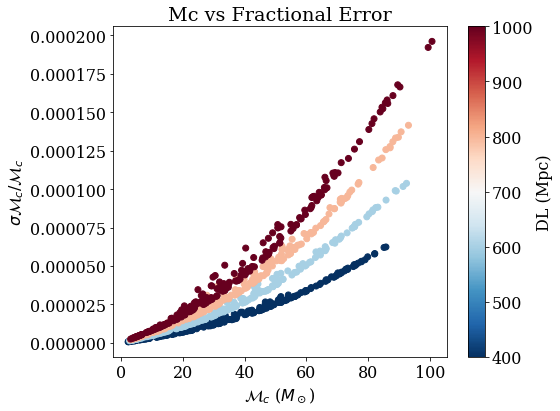

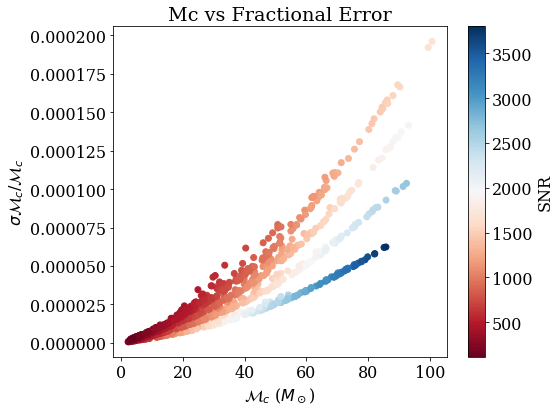

In [55]:
plot_bias_features(df["Mc"], df["Mc_stat_err"]/df["Mc"], df["DL"], colormap="RdBu_r",\
    title="Mc vs Fractional Error", xlabel="$\mathcal{M}_c$ ($M_\odot$)", ylabel="$\sigma{\mathcal{M}_c} / \mathcal{M}_c$", cbar_label="DL (Mpc)")

plot_bias_features(df["Mc"], df["Mc_stat_err"]/df["Mc"], df["snr"], colormap="RdBu",\
    title="Mc vs Fractional Error", xlabel="$\mathcal{M}_c$ ($M_\odot$)", ylabel="$\sigma{\mathcal{M}_c} / \mathcal{M}_c$", cbar_label="SNR")

The fractional 1 $\sigma$ error increases as a function of Mc, which happens to correspond to higher SNRs. This makes it appear as though the statsitical error increases with SNR, but that is a false correlation.
We can see this by systematically increasing or decreasing DL (SNR), which directly (inversely) changes the 1 $\sigma$ error as expected.

The bias is more significant for higher SNR, and less significant for lower SNR as expected. 

For binaries at a constant Luminosity distance, the SNR varies proportionally to total mass in the system, as expected. 

The deviations from a straight line come from variations in eta. 
The spread at low SNR comes from lower etas, which lead to lower biases.

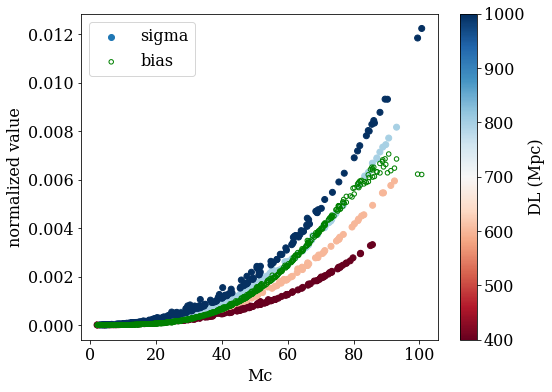

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

y1 = df["Mc_stat_err"]
y2 = df["full_bias"]

sc = plt.scatter(df["Mc"], y1/np.sum(y1), label="sigma", c=df["DL"], cmap='RdBu')
cbar = plt.colorbar(sc)
cbar.set_label("DL (Mpc)")

plt.scatter(df["Mc"], y2/np.sum(y2), label='bias', s=20, alpha=1, c='none', edgecolors='g', lw=1)
plt.ylabel("normalized value")
plt.xlabel("Mc")
plt.legend()
plt.show()

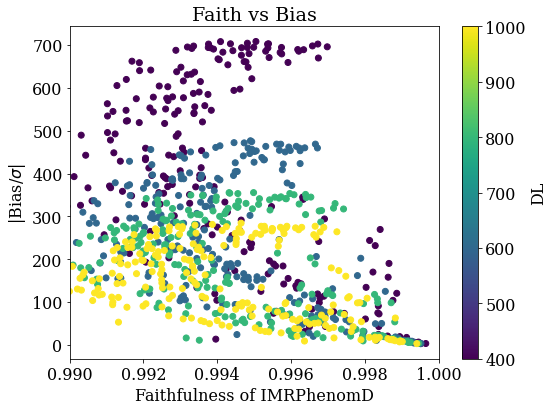

In [57]:
plot_bias_features(df["full_faith"], np.abs(df["full_bias"]/df["Mc_stat_err"]), df["DL"],\
    show_unbiased=False, colormap="viridis",\
    title="Faith vs Bias", xlabel="Faithfulness of IMRPhenomD", ylabel="|Bias/$\sigma$|", cbar_label="DL",\
    xlim=(0.99, 1.0))


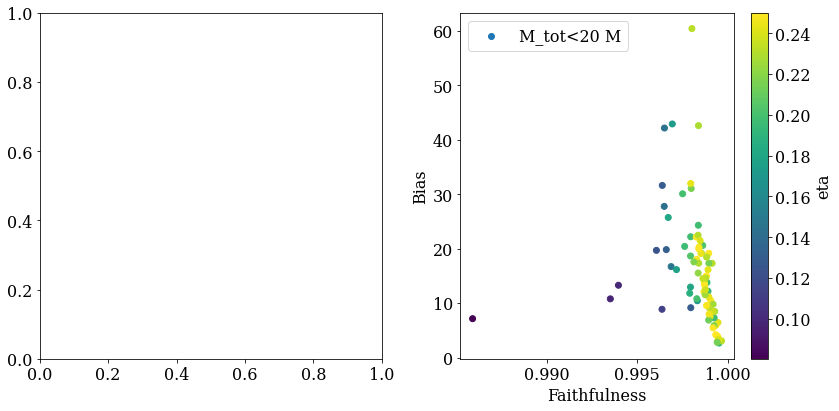

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

mmin = 1
mmax=20
x1 = df["full_faith"][(df["M_tot"]>mmin)* (df["M_tot"]<mmax)]
y1 = (df["full_bias"]/df["Mc_stat_err"])[(df["M_tot"]>mmin)* (df["M_tot"]<mmax)]
c1 = df["eta"][(df["M_tot"]>mmin)* (df["M_tot"]<mmax)]

# x2 = df["snr"][df["DL"]==1000]
# y2 = df["Mc_min_faith"][df["DL"]==1000]


# bins = np.linspace(0.996, 1.0, 20)
# ax1.hist(y1, bins, histtype='step', label="DL=400 Mpc")
# ax1.hist(y2, bins, histtype='step', label="DL=1000 Mpc")
# ax1.set_xlabel("Min Faithfulness")
# ax1.set_xticks(np.linspace(0.996, 1.0, 5))
# ax1.legend(loc="upper left")

sc=ax2.scatter(x1, y1, c=c1, cmap='viridis', label=f"M_tot<{mmax} M")
cbar = plt.colorbar(sc)
cbar.set_label("eta")
# ax2.scatter(x2, y2, label="DL=1000 Mpc")
ax2.set_xlabel("Faithfulness")
ax2.set_ylabel("Bias")
# ax2.set_ylim(0.996, 1.0001)
ax2.legend()

fig.tight_layout()
plt.show()

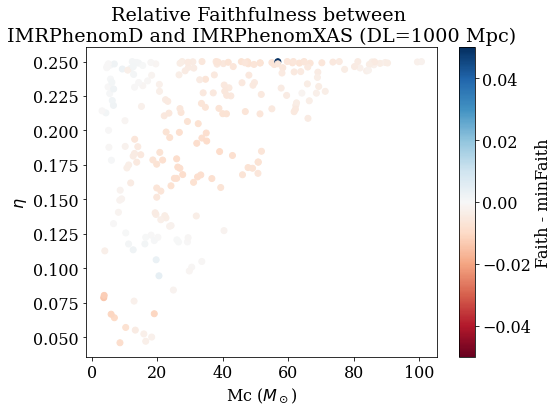

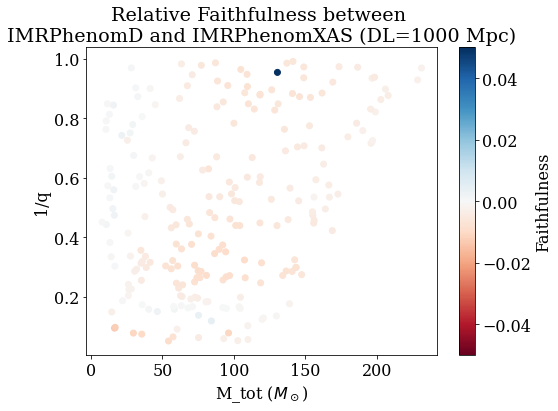

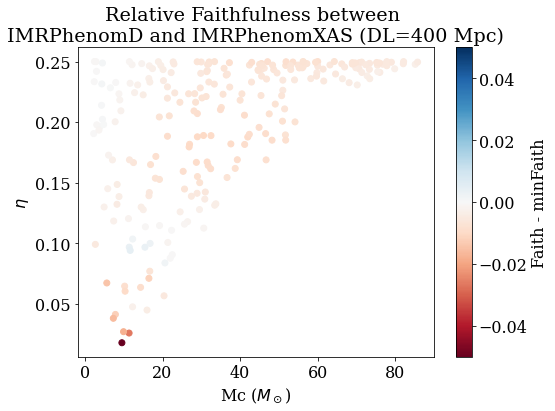

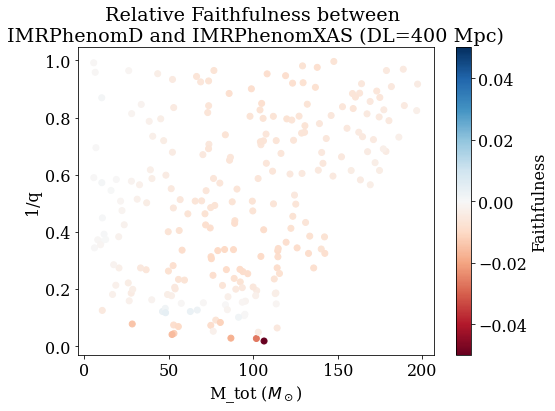

In [27]:
plot_bias_features(df["Mc"], df["eta"], df["full_faith"] - df["Mc_min_faith"], show_unbiased=False, colormap="RdBu", DL=1000,\
    title="Relative Faithfulness between \nIMRPhenomD and IMRPhenomXAS", xlabel="Mc ($M_\odot$)", ylabel="$\eta$", cbar_label="Faith - minFaith",\
        vmin=-0.05, vmax=0.05)

plot_bias_features(df["M_tot"], 1/df["q"], df["full_faith"] - df["Mc_min_faith"], show_unbiased=False, colormap="RdBu", DL=1000,\
    title="Relative Faithfulness between \nIMRPhenomD and IMRPhenomXAS", xlabel="M_tot ($M_\odot$)", ylabel="1/q", cbar_label="Faithfulness",\
        vmin=-0.05, vmax=0.05)

plot_bias_features(df["Mc"], df["eta"], df["full_faith"] - df["Mc_min_faith"], show_unbiased=False, colormap="RdBu", DL=400,\
    title="Relative Faithfulness between \nIMRPhenomD and IMRPhenomXAS", xlabel="Mc ($M_\odot$)", ylabel="$\eta$", cbar_label="Faith - minFaith",\
        vmin=-0.05, vmax=0.05)

plot_bias_features(df["M_tot"], 1/df["q"], df["full_faith"] - df["Mc_min_faith"], show_unbiased=False, colormap="RdBu", DL=400,\
    title="Relative Faithfulness between \nIMRPhenomD and IMRPhenomXAS", xlabel="M_tot ($M_\odot$)", ylabel="1/q", cbar_label="Faithfulness",\
        vmin=-0.05, vmax=0.05)

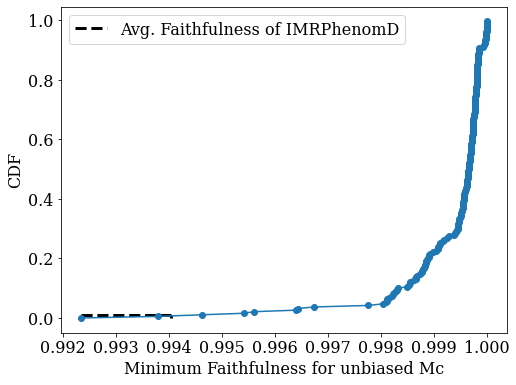

About 60% of the events require higher faithfulness


In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
  
# sort the data in ascending order
x = np.sort(df["Mc_min_faith"])
N = len(df["Mc_min_faith"])  
avg_faith = np.average(df["full_faith"])
# get the cdf values of y
cdf = np.arange(N) / float(N)

plt.plot(x, cdf, marker='o')

# plotting
plt.xlabel('Minimum Faithfulness for unbiased Mc')
plt.ylabel('CDF')
  
y_int = cdf[np.where(x>=avg_faith)[0][0]]

# plt.axvline(x=avg_faith, color='k', lw=3, linestyle='--', label="Avg. Faithfulness of IMRPhenomD")
ax.vlines(x=avg_faith, ymin=0, ymax=y_int, color='k', lw=3, linestyle='--', label="Avg. Faithfulness of IMRPhenomD")
ax.hlines(y=y_int, xmin=x[0], xmax=avg_faith, lw=3, linestyle='--', color='k')
plt.legend()

plt.show()

print("About 60% of the events require higher faithfulness")